#Requirements

In [ ]:
!pip install tqdm
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.0 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from imblearn.over_sampling import SMOTE
from scipy.linalg import svdvals
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Dataset

In [ ]:
dataset_label = {
  0 : "Cobaltstrike",
  1 : "Bruteratel",
  2 : "Covenant",
  3 : "Deimos",
  4 : "Sliver",
  5 : "Posh",
  6 : "Metsploit"
}

In [ ]:
unbalanced_dataset = pd.read_csv("result.csv")
unbalanced_dataset["label"] = unbalanced_dataset.label.astype("int64")
unbalanced_dataset

,data,node,edge,pcap_status,xml,ctldl,label
0,Adobe_XMP_Identifier SizeofResource WriteProce...,411,426,1,1.0,1.0,1
1,T1129 T1569.002 ChangeServiceConfig2A ChangeSe...,0,0,1,1.0,1.0,1
2,T1213 T1056.001 T1222 T1562.004 T1112 T1027.00...,0,0,1,1.0,1.0,1
3,brc4_shellcode HKTL_BruteRatel_Badger_Indicato...,0,0,1,0.0,0.0,1
4,ExitProcess HeapSize UnhandledExceptionFilter ...,0,0,0,0.5,0.5,1
...,...,...,...,...,...,...,...
431,WriteFile WriteConsoleW WaitForSingleObject Vi...,0,0,1,0.0,0.0,4
432,WriteFile WriteConsoleW WaitForSingleObject Vi...,0,0,1,1.0,1.0,4
433,WriteFile WriteConsoleW WaitForSingleObject Vi...,0,0,1,0.0,0.0,4
434,WriteFile WriteConsoleW WaitForSingleObject Vi...,0,0,1,1.0,1.0,4


In [ ]:
data_column = unbalanced_dataset["data"]
element_counts = []

for sentence in data_column:
    elements = sentence.split()
    element_count = len(elements)
    element_counts.append(element_count)

a = 0
b = 0
for i, count in enumerate(element_counts, start=1):
    print(f"Sentence {i}: {count} elements")
    a += 1
    b += count

print(b / a)

Sentence 1: 241 elements
Sentence 2: 163 elements
Sentence 3: 575 elements
Sentence 4: 511 elements
Sentence 5: 438 elements
Sentence 6: 443 elements
Sentence 7: 462 elements
Sentence 8: 190 elements
Sentence 9: 15 elements
Sentence 10: 201 elements
Sentence 11: 254 elements
Sentence 12: 200 elements
Sentence 13: 3 elements
Sentence 14: 137 elements
Sentence 15: 275 elements
Sentence 16: 183 elements
Sentence 17: 205 elements
Sentence 18: 143 elements
Sentence 19: 382 elements
Sentence 20: 146 elements
Sentence 21: 147 elements
Sentence 22: 638 elements
Sentence 23: 816 elements
Sentence 24: 566 elements
Sentence 25: 565 elements
Sentence 26: 567 elements
Sentence 27: 497 elements
Sentence 28: 568 elements
Sentence 29: 497 elements
Sentence 30: 580 elements
Sentence 31: 159 elements
Sentence 32: 646 elements
Sentence 33: 504 elements
Sentence 34: 362 elements
Sentence 35: 195 elements
Sentence 36: 544 elements
Sentence 37: 300 elements
Sentence 38: 172 elements
Sentence 39: 48 elements

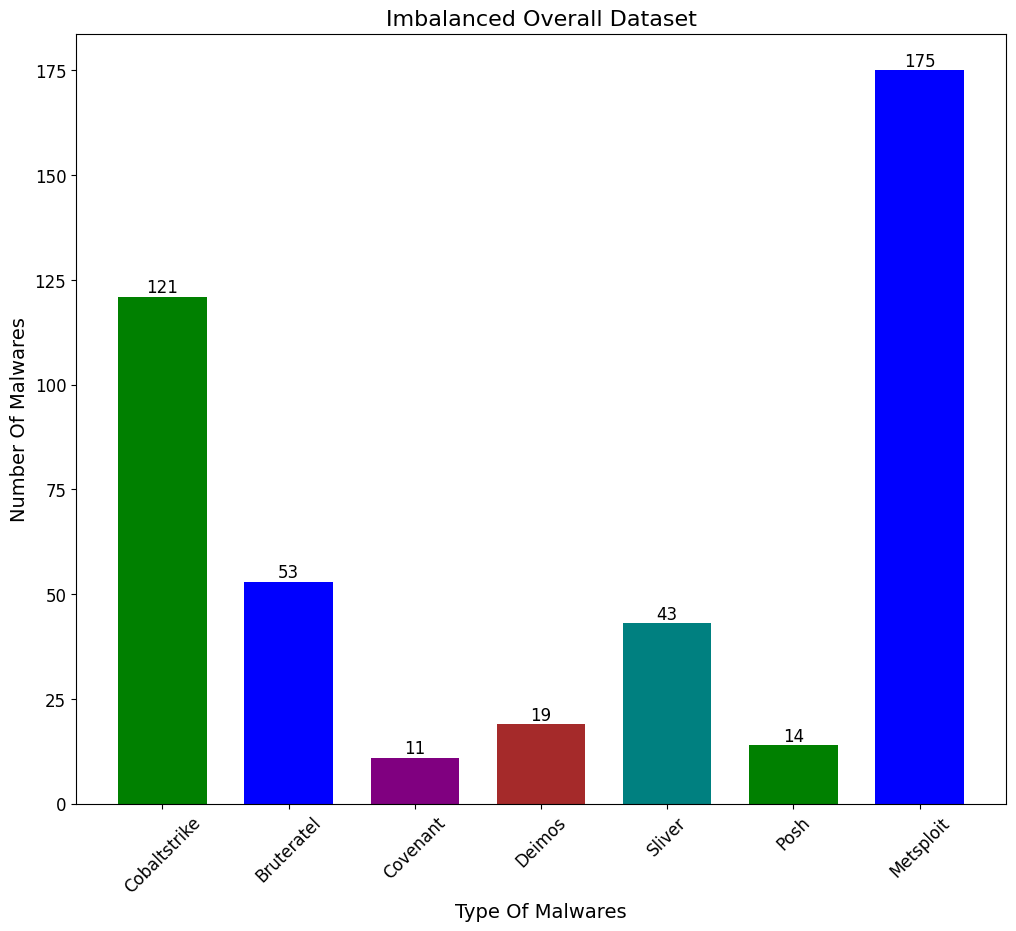

In [ ]:
unbalanced_dataset_size = unbalanced_dataset["label"].value_counts().to_dict()
unbalanced_dataset_size = {k: v for k, v in sorted(list(unbalanced_dataset_size.items()))}

names = list(dataset_label.values())
values = list(unbalanced_dataset_size.values())
New_Colors = ["green","blue","purple","brown","teal"]
plt.figure(figsize=(12,10))
plt.bar(names,values,color=New_Colors,width=0.7)

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, fontsize= 12)
plt.yticks(fontsize= 12)
plt.title("Imbalanced Overall Dataset",fontsize=16)
plt.xlabel("Type Of Malwares", fontsize=14)
plt.ylabel("Number Of Malwares", fontsize=14)
plt.show()

#Word Embedding

Word2Vec

In [ ]:
def api_sequence_to_vector(api_sequence, model, v_size):
    vector = []
    for api in api_sequence[:v_size]:
        if api in model.wv:
            vector.append(model.wv[api])
        else:
            vector.append([0] * v_size)

    # Padding
    while len(vector) < v_size:
        vector.append([0] * v_size)

    return vector

In [ ]:
unbalanced_dataset["data"] = unbalanced_dataset["data"].str.split()
unbalanced_dataset

,data,node,edge,pcap_status,xml,ctldl,label
0,"[Adobe_XMP_Identifier, SizeofResource, WritePr...",411,426,1,1.0,1.0,1
1,"[T1129, T1569.002, ChangeServiceConfig2A, Chan...",0,0,1,1.0,1.0,1
2,"[T1213, T1056.001, T1222, T1562.004, T1112, T1...",0,0,1,1.0,1.0,1
3,"[brc4_shellcode, HKTL_BruteRatel_Badger_Indica...",0,0,1,0.0,0.0,1
4,"[ExitProcess, HeapSize, UnhandledExceptionFilt...",0,0,0,0.5,0.5,1
...,...,...,...,...,...,...,...
431,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,1,0.0,0.0,4
432,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,1,1.0,1.0,4
433,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,1,0.0,0.0,4
434,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,1,1.0,1.0,4


In [ ]:
vec_dim = 128
model = Word2Vec(unbalanced_dataset["data"], vector_size=vec_dim, window=5, min_count=1, sg=0, epochs=50)

In [ ]:
unbalanced_dataset["data_matrix"] = unbalanced_dataset["data"].apply(lambda x: api_sequence_to_vector(x, model, vec_dim))
unbalanced_dataset = unbalanced_dataset.drop(columns=["data"])
unbalanced_dataset

,node,edge,pcap_status,xml,ctldl,label,data_matrix
0,411,426,1,1.0,1.0,1,"[[-0.05250034, 0.12531547, -0.19079863, 0.1092..."
1,0,0,1,1.0,1.0,1,"[[-1.2297436, -0.41372123, 0.03405275, 0.02421..."
2,0,0,1,1.0,1.0,1,"[[-0.014871956, -0.07744145, -0.011482332, 0.0..."
3,0,0,1,0.0,0.0,1,"[[-0.31875104, -0.22358729, 0.1493289, 0.67949..."
4,0,0,0,0.5,0.5,1,"[[-2.5223024, 1.5918328, -1.1516758, -0.672141..."
...,...,...,...,...,...,...,...
431,0,0,1,0.0,0.0,4,"[[-2.4090402, 0.6022615, 1.0041685, 2.1388419,..."
432,0,0,1,1.0,1.0,4,"[[-2.4090402, 0.6022615, 1.0041685, 2.1388419,..."
433,0,0,1,0.0,0.0,4,"[[-2.4090402, 0.6022615, 1.0041685, 2.1388419,..."
434,0,0,1,1.0,1.0,4,"[[-2.4090402, 0.6022615, 1.0041685, 2.1388419,..."


SVD

In [ ]:
def calculate_eigenvalue(matrix):
    singular_values = svdvals(matrix)
    eigenvalue_vector = singular_values[:vec_dim]
    return eigenvalue_vector

In [ ]:
unbalanced_dataset["data_vector"] = unbalanced_dataset["data_matrix"].apply(calculate_eigenvalue)
unbalanced_dataset = unbalanced_dataset.drop(columns=["data_matrix"])
unbalanced_dataset

,node,edge,pcap_status,xml,ctldl,label,data_vector
0,411,426,1,1.0,1.0,1,"[56.832096, 44.370804, 36.05482, 30.1531, 27.5..."
1,0,0,1,1.0,1.0,1,"[59.84128, 49.27112, 37.054806, 35.321064, 32...."
2,0,0,1,1.0,1.0,1,"[84.79629, 35.887043, 32.87073, 30.984478, 28...."
3,0,0,1,0.0,0.0,1,"[88.918015, 36.66783, 36.03541, 30.690172, 29...."
4,0,0,0,0.5,0.5,1,"[89.4413, 36.868675, 36.706215, 30.774433, 29...."
...,...,...,...,...,...,...,...
431,0,0,1,0.0,0.0,4,"[59.92463553081585, 34.501400350643316, 31.035..."
432,0,0,1,1.0,1.0,4,"[60.79475, 49.92169, 36.497353, 33.21546, 31.3..."
433,0,0,1,0.0,0.0,4,"[59.78419554648347, 36.33839704964937, 32.2747..."
434,0,0,1,1.0,1.0,4,"[59.81882, 50.176525, 36.398216, 33.033947, 31..."


#Dataset Split

In [ ]:
X = unbalanced_dataset[["data_vector", "node", "edge", "pcap_status", "xml", "ctldl"]]
y = unbalanced_dataset["label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

Plot

In [ ]:
def plot_dataset(data_df, title):
  plt.figure(figsize=(12, 6))
  label_counts = data_df.value_counts()
  label_names = [dataset_label[label] for label in label_counts.index]
  New_Colors = ["green","blue","purple","brown","teal"]
  plt.bar(label_names, label_counts.values, color=New_Colors, width=0.7)

  for i, v in enumerate(label_counts.values):
      plt.text(i, v, str(v), ha="center", va="bottom", fontsize=12)

  plt.xticks(rotation=45, fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(title, fontsize=16)
  plt.xlabel("Type Of Malwares", fontsize=14)
  plt.ylabel("Number Of Malwares", fontsize=14)
  plt.show()

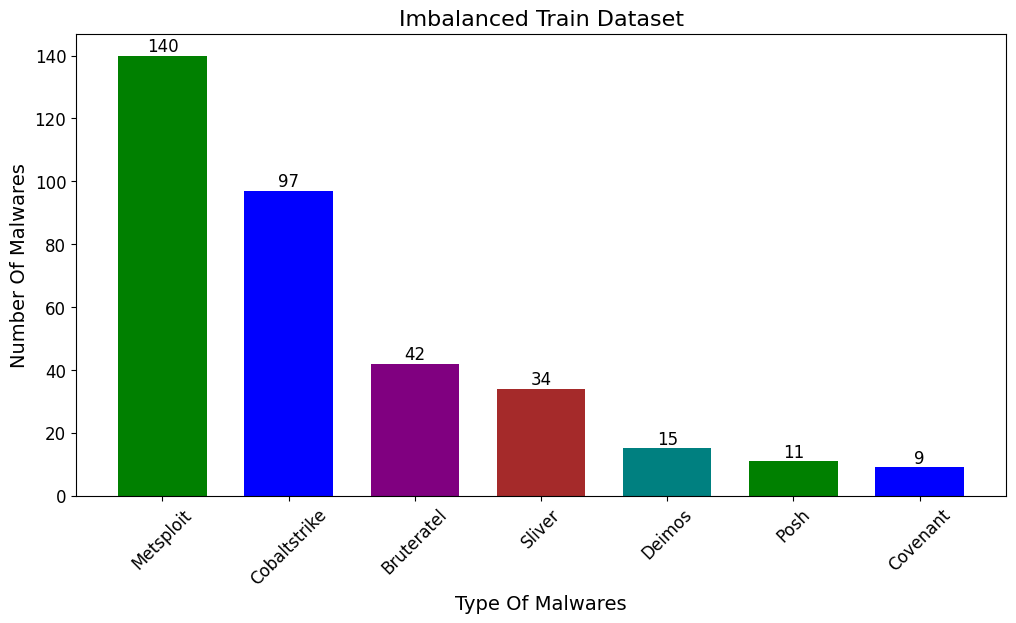

In [ ]:
plot_dataset(y_train, "Imbalanced Train Dataset")

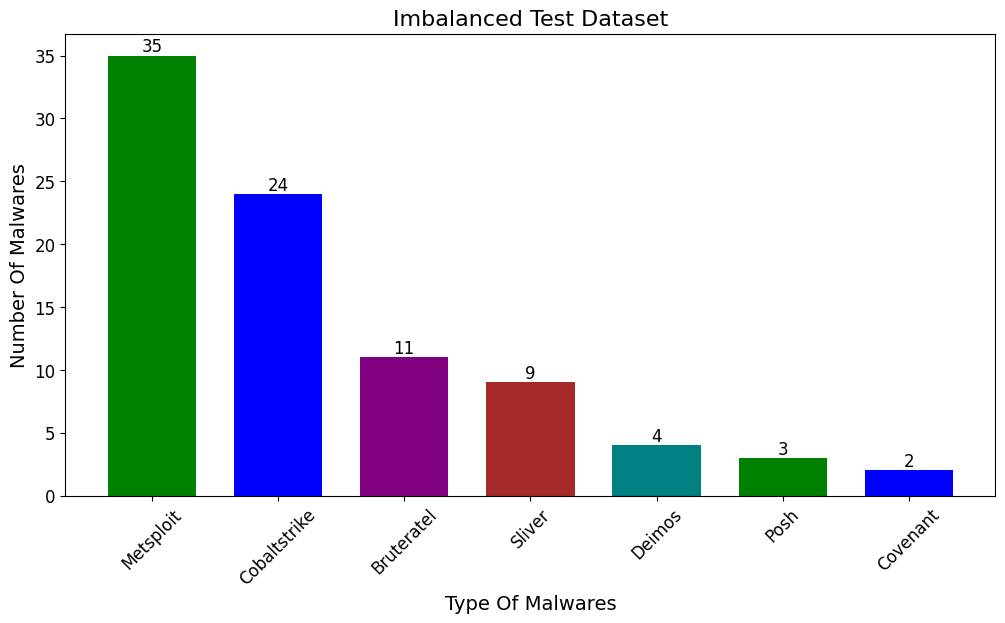

In [ ]:
plot_dataset(y_test, "Imbalanced Test Dataset")

#Dataset Balancing

Train data balancing

In [ ]:
class_counts = y_train.value_counts()
target_count = 100

balanced_X_train = pd.DataFrame()
balanced_y_train = pd.Series()

for label, count in class_counts.items():
    # Under-sampling
    if count < target_count:
        sampled_X_train = resample(X_train[y_train == label], n_samples=target_count, replace=True)
        sampled_y_train = pd.Series([label] * target_count)
    # Over-sampling
    elif count > target_count:
        sampled_X_train = resample(X_train[y_train == label], n_samples=target_count, replace=False)
        sampled_y_train = pd.Series([label] * target_count)
    else:
        sampled_X_train = X_train[y_train == label]
        sampled_y_train = pd.Series([label] * count)

    balanced_X_train = pd.concat([balanced_X_train, sampled_X_train])
    balanced_y_train = pd.concat([balanced_y_train, sampled_y_train])

X_train_balanced = balanced_X_train
y_train_balanced = balanced_y_train

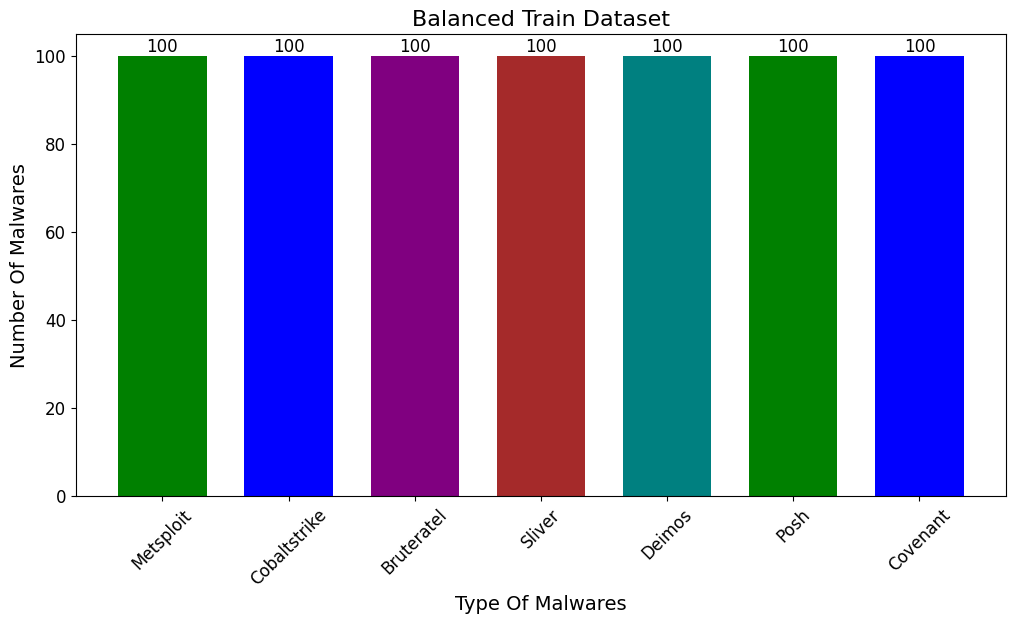

In [ ]:
plot_dataset(y_train_balanced, "Balanced Train Dataset")

Test data balancing

In [ ]:
class_counts_test = y_test.value_counts()
target_count_test = 25

balanced_X_test = pd.DataFrame()
balanced_y_test = pd.Series()

for label, count in class_counts_test.items():
    # Under-sampling
    if count < target_count_test:
        sampled_X_test = resample(X_test[y_test == label], n_samples=target_count_test, replace=True)
        sampled_y_test = pd.Series([label] * target_count_test)
    # Over-sampling
    elif count > target_count_test:
        sampled_X_test = resample(X_test[y_test == label], n_samples=target_count_test, replace=False)
        sampled_y_test = pd.Series([label] * target_count_test)
    else:
        sampled_X_test = X_test[y_test == label]
        sampled_y_test = pd.Series([label] * count)

    balanced_X_test = pd.concat([balanced_X_test, sampled_X_test])
    balanced_y_test = pd.concat([balanced_y_test, sampled_y_test])

X_test_balanced = balanced_X_test
y_test_balanced = balanced_y_test

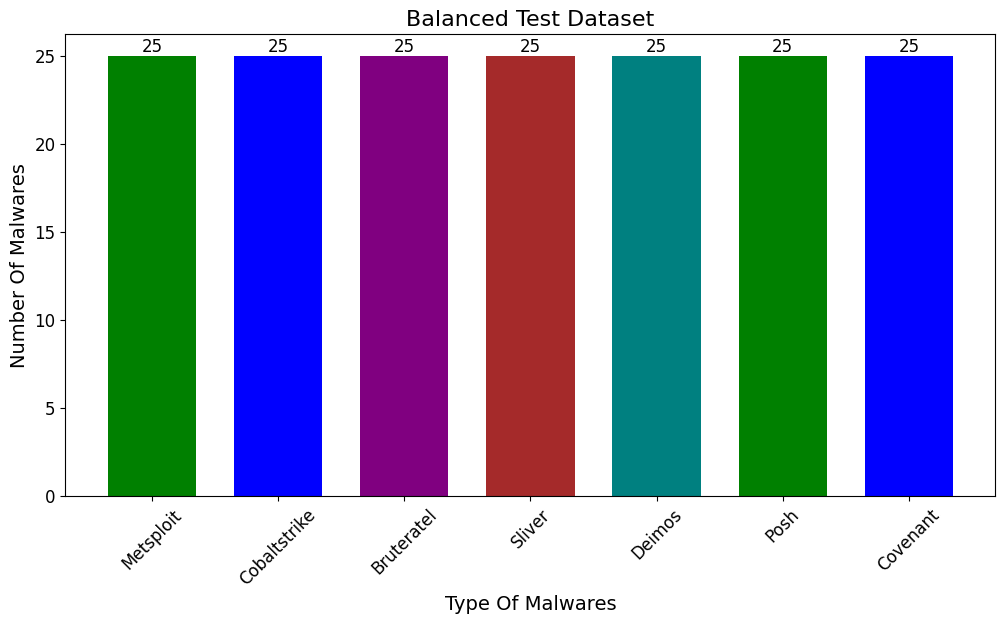

In [ ]:
plot_dataset(y_test_balanced, "Balanced Test Dataset")

#Data Unpacking

In [ ]:
for i in range(vec_dim):
    X_train_balanced[f"data_element_{i}"] = X_train_balanced["data_vector"].apply(lambda x: x[i])
    X_test_balanced[f"data_element_{i}"] = X_test_balanced["data_vector"].apply(lambda x: x[i])

In [ ]:
X_train_balanced = X_train_balanced.drop(columns=["data_vector"])
X_test_balanced = X_test_balanced.drop(columns=["data_vector"])

In [ ]:
X_train_balanced

,node,edge,pcap_status,xml,ctldl,data_element_0,data_element_1,data_element_2,data_element_3,data_element_4,...,data_element_118,data_element_119,data_element_120,data_element_121,data_element_122,data_element_123,data_element_124,data_element_125,data_element_126,data_element_127
332,0,0,0,0.5,0.5,87.006813,40.321537,36.561344,34.721420,31.866058,...,0.058626,0.048097,0.034865,0.033315,0.026587,0.024130,0.016836,0.013100,0.008962,0.006416
255,0,0,1,1.0,1.0,62.584404,48.888477,31.332798,29.673874,28.288084,...,0.030311,0.023450,0.021511,0.018716,0.012197,0.011170,0.008635,0.006253,0.003206,0.002256
374,0,0,1,0.0,0.0,73.798088,39.924797,34.774105,32.566540,31.026955,...,0.027653,0.026714,0.022521,0.020901,0.018763,0.012537,0.008069,0.006893,0.004698,0.001372
337,0,0,1,0.0,0.0,87.006813,40.321537,36.561344,34.721420,31.866058,...,0.058626,0.048097,0.034865,0.033315,0.026587,0.024130,0.016836,0.013100,0.008962,0.006416
347,0,0,0,0.5,0.5,87.006813,40.321537,36.561344,34.721420,31.866058,...,0.058626,0.048097,0.034865,0.033315,0.026587,0.024130,0.016836,0.013100,0.008962,0.006416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,0,0,1,0.0,0.0,66.398804,38.219780,29.706211,27.864874,26.232718,...,0.022890,0.017754,0.015423,0.014811,0.010125,0.008505,0.005682,0.003298,0.002374,0.000125
186,0,0,1,1.0,1.0,61.250748,49.054646,32.410841,28.247171,26.263676,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
184,0,0,1,1.0,0.0,52.157537,39.056765,34.472614,26.381501,25.745098,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
182,189,94,1,1.0,1.0,60.803211,48.274040,31.427752,27.922553,26.346309,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
X_test_balanced

,node,edge,pcap_status,xml,ctldl,data_element_0,data_element_1,data_element_2,data_element_3,data_element_4,...,data_element_118,data_element_119,data_element_120,data_element_121,data_element_122,data_element_123,data_element_124,data_element_125,data_element_126,data_element_127
211,0,0,1,0.0,0.0,58.560043,39.972958,35.081314,32.712891,27.415056,...,2.565073e-02,2.471198e-02,2.044989e-02,1.865428e-02,1.665793e-02,1.453008e-02,1.082586e-02,8.819940e-03,5.257761e-03,1.794419e-03
356,0,0,0,0.5,0.5,87.006813,40.321537,36.561344,34.721420,31.866058,...,5.862610e-02,4.809725e-02,3.486481e-02,3.331486e-02,2.658710e-02,2.412965e-02,1.683622e-02,1.310044e-02,8.961631e-03,6.415984e-03
242,0,0,0,0.5,0.5,7.196401,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
279,0,0,0,0.5,0.5,90.582589,45.861916,40.543932,33.300342,31.930673,...,3.424440e-16,2.943808e-16,2.048964e-16,1.355612e-16,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
271,0,0,1,0.0,0.0,90.602524,46.738407,40.998192,33.393917,32.084721,...,4.106815e-07,3.376861e-07,2.868928e-07,2.441213e-07,2.157961e-07,1.824736e-07,1.414083e-07,1.120143e-07,4.149433e-08,3.469830e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,0,0,1,1.0,1.0,57.147910,45.284883,30.729755,27.569714,24.953680,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
178,0,0,1,1.0,1.0,57.147910,45.284883,30.729755,27.569714,24.953680,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
185,0,0,1,1.0,0.0,72.510353,39.528030,35.661839,31.105650,28.957634,...,3.213125e-02,2.873990e-02,2.387859e-02,2.065140e-02,1.629298e-02,1.144943e-02,9.146347e-03,7.693890e-03,5.352458e-03,2.167340e-03
185,0,0,1,1.0,0.0,72.510353,39.528030,35.661839,31.105650,28.957634,...,3.213125e-02,2.873990e-02,2.387859e-02,2.065140e-02,1.629298e-02,1.144943e-02,9.146347e-03,7.693890e-03,5.352458e-03,2.167340e-03


#Classifier

Grid Search

In [ ]:
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 10]
}

param_grid_xgb = {
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [100, 200, 300],
    "max_depth": [6, 8, 10],
    "min_child_weight": [1, 3, 5]
}

param_grid_lgbm = {
    "learning_rate": [0.1, 0.01, 0.001],
    "n_estimators": [100, 200, 300],
    "max_depth": [6, 8, 10],
    "min_child_samples": [10, 20, 30]
}

param_grid_catboost = {
    "iterations": [100, 200, 300],
    "learning_rate": [0.1, 0.01, 0.001]
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5)
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid_xgb, cv=5)
grid_search_lgbm = GridSearchCV(estimator=LGBMClassifier(), param_grid=param_grid_lgbm, cv=5)
grid_search_catboost = GridSearchCV(estimator=CatBoostClassifier(), param_grid=param_grid_catboost, cv=5)

grid_search_rf.fit(X_train_balanced, y_train_balanced)
grid_search_xgb.fit(X_train_balanced, y_train_balanced)
grid_search_lgbm.fit(X_train_balanced, y_train_balanced)
grid_search_catboost.fit(X_train_balanced, y_train_balanced)

print("Random Forest Best Parameters:", grid_search_rf.best_params_)
print("XGBoost Best Parameters:", grid_search_xgb.best_params_)
print("LightGBM Best Parameters:", grid_search_lgbm.best_params_)
print("CatBoost Best Parameters:", grid_search_catboost.best_params_)
'''

'\nparam_grid_rf = {\n    "n_estimators": [100, 200, 300],\n    "max_depth": [10, 20, 30],\n    "min_samples_split": [2, 5, 10]\n}\n\nparam_grid_xgb = {\n    "learning_rate": [0.1, 0.01, 0.001],\n    "n_estimators": [100, 200, 300],\n    "max_depth": [6, 8, 10],\n    "min_child_weight": [1, 3, 5]\n}\n\nparam_grid_lgbm = {\n    "learning_rate": [0.1, 0.01, 0.001],\n    "n_estimators": [100, 200, 300],\n    "max_depth": [6, 8, 10],\n    "min_child_samples": [10, 20, 30]\n}\n\nparam_grid_svc = {\n    "C": [0.1, 1, 10],\n    "kernel": ["rbf"],\n    "gamma": ["scale"]\n}\n\nparam_grid_catboost = {\n    "iterations": [100, 200, 300],\n    "learning_rate": [0.1, 0.01, 0.001]\n}\n\ngrid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=5)\ngrid_search_xgb = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid_xgb, cv=5)\ngrid_search_lgbm = GridSearchCV(estimator=LGBMClassifier(), param_grid=param_grid_lgbm, cv=5)\n#grid_search_svc = GridSearchCV

In [ ]:
rf_classifier = RandomForestClassifier(
    max_depth=10,
    n_estimators=100,
    min_samples_split=2
)

xgb_classifier = XGBClassifier(
    learning_rate=0.1,
    max_depth=6,
    n_estimators=300,
    min_child_weight=1
)

lgbm_classifier = LGBMClassifier(
    learning_rate=0.01,
    max_depth=6,
    min_child_samples=10,
    n_estimators=300
)

svc_classifier = SVC(
    C=10.0,
    kernel="rbf",
    gamma="scale"
)

catboost_classifier = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1
)

classifiers = [
    rf_classifier,
    xgb_classifier,
    lgbm_classifier,
    #svc_classifier,
    catboost_classifier
]

Train

In [ ]:
results = {clf.__class__.__name__: {"accuracy": [], "precision": [], "recall": [], "f1": []} for clf in classifiers}

In [ ]:
for clf in classifiers:
    for _ in tqdm(range(10)):
        clf.fit(X_train_balanced, y_train_balanced)
        y_pred = clf.predict(X_test_balanced)
        accuracy = accuracy_score(y_test_balanced, y_pred)
        precision = precision_score(y_test_balanced, y_pred, average="weighted")
        recall = recall_score(y_test_balanced, y_pred, average="weighted")
        f1 = f1_score(y_test_balanced, y_pred, average="weighted")

        results[clf.__class__.__name__]["accuracy"].append(accuracy)
        results[clf.__class__.__name__]["precision"].append(precision)
        results[clf.__class__.__name__]["recall"].append(recall)
        results[clf.__class__.__name__]["f1"].append(f1)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13453
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 133
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM

 10%|█         | 1/10 [00:09<01:27,  9.76s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13453
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 133
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.9459

 20%|██        | 2/10 [00:16<01:03,  7.90s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13453
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 133
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.9459

 30%|███       | 3/10 [00:25<00:59,  8.53s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13453
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 133
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.9459

 40%|████      | 4/10 [00:32<00:46,  7.73s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13453
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 133
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.9459

 50%|█████     | 5/10 [00:40<00:39,  7.95s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001496 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13453
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 133
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.9459

 60%|██████    | 6/10 [00:47<00:29,  7.50s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13453
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 133
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from sco

 70%|███████   | 7/10 [00:55<00:23,  7.77s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13453
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 133
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.9459

 80%|████████  | 8/10 [01:02<00:14,  7.43s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13453
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 133
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.9459

 90%|█████████ | 9/10 [01:10<00:07,  7.80s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13453
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 133
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.9459

100%|██████████| 10/10 [01:17<00:00,  7.76s/it]


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 1.7951354	total: 240ms	remaining: 23.8s
1:	learn: 1.6366681	total: 376ms	remaining: 18.4s
2:	learn: 1.5343279	total: 529ms	remaining: 17.1s
3:	learn: 1.4453214	total: 667ms	remaining: 16s
4:	learn: 1.3813290	total: 815ms	remaining: 15.5s
5:	learn: 1.3043749	total: 943ms	remaining: 14.8s
6:	learn: 1.2429475	total: 1.09s	remaining: 14.5s
7:	learn: 1.1957998	total: 1.22s	remaining: 14.1s
8:	learn: 1.1455006	total: 1.37s	remaining: 13.8s
9:	learn: 1.1007977	total: 1.5s	remaining: 13.5s
10:	learn: 1.0601996	total: 1.7s	remaining: 13.8s
11:	learn: 1.0231942	total: 1.92s	remaining: 14.1s
12:	learn: 0.9868209	total: 2.11s	remaining: 14.2s
13:	learn: 0.9612808	total: 2.34s	remaining: 14.4s
14:	learn: 0.9325965	total: 2.56s	remaining: 14.5s
15:	learn: 0.9045513	total: 2.83s	remaining: 14.9s
16:	learn: 0.8826111	total: 3.08s	remaining: 15.1s
17:	learn: 0.8571043	total: 3.32s	remaining: 15.1s
18:	learn: 0.8390062	total: 3.56s	remaining: 15.2s
19:	learn: 0.8231496	total: 3.82s	remaining: 

 10%|█         | 1/10 [00:16<02:25, 16.16s/it]

98:	learn: 0.3250755	total: 15.9s	remaining: 160ms
99:	learn: 0.3200490	total: 16s	remaining: 0us
0:	learn: 1.7951354	total: 201ms	remaining: 19.9s
1:	learn: 1.6366681	total: 335ms	remaining: 16.4s
2:	learn: 1.5343279	total: 485ms	remaining: 15.7s
3:	learn: 1.4453214	total: 629ms	remaining: 15.1s
4:	learn: 1.3813290	total: 831ms	remaining: 15.8s
5:	learn: 1.3043749	total: 1.06s	remaining: 16.6s
6:	learn: 1.2429475	total: 1.32s	remaining: 17.5s
7:	learn: 1.1957998	total: 1.56s	remaining: 17.9s
8:	learn: 1.1455006	total: 1.81s	remaining: 18.3s
9:	learn: 1.1007977	total: 2.06s	remaining: 18.6s
10:	learn: 1.0601996	total: 2.32s	remaining: 18.8s
11:	learn: 1.0231942	total: 2.57s	remaining: 18.8s
12:	learn: 0.9868209	total: 2.81s	remaining: 18.8s
13:	learn: 0.9612808	total: 3.04s	remaining: 18.7s
14:	learn: 0.9325965	total: 3.29s	remaining: 18.7s
15:	learn: 0.9045513	total: 3.54s	remaining: 18.6s
16:	learn: 0.8826111	total: 3.79s	remaining: 18.5s
17:	learn: 0.8571043	total: 4s	remaining: 18.

 20%|██        | 2/10 [00:32<02:09, 16.25s/it]

99:	learn: 0.3200490	total: 16.2s	remaining: 0us
0:	learn: 1.7951354	total: 336ms	remaining: 33.3s
1:	learn: 1.6366681	total: 612ms	remaining: 30s
2:	learn: 1.5343279	total: 886ms	remaining: 28.7s
3:	learn: 1.4453214	total: 1.1s	remaining: 26.5s
4:	learn: 1.3813290	total: 1.34s	remaining: 25.5s
5:	learn: 1.3043749	total: 1.59s	remaining: 24.9s
6:	learn: 1.2429475	total: 1.83s	remaining: 24.3s
7:	learn: 1.1957998	total: 2.08s	remaining: 23.9s
8:	learn: 1.1455006	total: 2.34s	remaining: 23.6s
9:	learn: 1.1007977	total: 2.6s	remaining: 23.4s
10:	learn: 1.0601996	total: 2.83s	remaining: 22.9s
11:	learn: 1.0231942	total: 3.07s	remaining: 22.5s
12:	learn: 0.9868209	total: 3.3s	remaining: 22.1s
13:	learn: 0.9612808	total: 3.54s	remaining: 21.8s
14:	learn: 0.9325965	total: 3.77s	remaining: 21.3s
15:	learn: 0.9045513	total: 4s	remaining: 21s
16:	learn: 0.8826111	total: 4.22s	remaining: 20.6s
17:	learn: 0.8571043	total: 4.43s	remaining: 20.2s
18:	learn: 0.8390062	total: 4.59s	remaining: 19.6s
19

 30%|███       | 3/10 [00:49<01:55, 16.48s/it]

99:	learn: 0.3200490	total: 16.6s	remaining: 0us
0:	learn: 1.7951354	total: 341ms	remaining: 33.8s
1:	learn: 1.6366681	total: 593ms	remaining: 29.1s
2:	learn: 1.5343279	total: 845ms	remaining: 27.3s
3:	learn: 1.4453214	total: 1.08s	remaining: 26s
4:	learn: 1.3813290	total: 1.34s	remaining: 25.4s
5:	learn: 1.3043749	total: 1.58s	remaining: 24.8s
6:	learn: 1.2429475	total: 1.81s	remaining: 24.1s
7:	learn: 1.1957998	total: 2.05s	remaining: 23.6s
8:	learn: 1.1455006	total: 2.28s	remaining: 23s
9:	learn: 1.1007977	total: 2.54s	remaining: 22.9s
10:	learn: 1.0601996	total: 2.76s	remaining: 22.3s
11:	learn: 1.0231942	total: 2.92s	remaining: 21.4s
12:	learn: 0.9868209	total: 3.08s	remaining: 20.6s
13:	learn: 0.9612808	total: 3.2s	remaining: 19.7s
14:	learn: 0.9325965	total: 3.35s	remaining: 19s
15:	learn: 0.9045513	total: 3.49s	remaining: 18.3s
16:	learn: 0.8826111	total: 3.64s	remaining: 17.8s
17:	learn: 0.8571043	total: 3.77s	remaining: 17.2s
18:	learn: 0.8390062	total: 3.92s	remaining: 16.7s

 40%|████      | 4/10 [01:06<01:40, 16.69s/it]

99:	learn: 0.3200490	total: 16.8s	remaining: 0us
0:	learn: 1.7951354	total: 322ms	remaining: 31.9s
1:	learn: 1.6366681	total: 541ms	remaining: 26.5s
2:	learn: 1.5343279	total: 765ms	remaining: 24.7s
3:	learn: 1.4453214	total: 929ms	remaining: 22.3s
4:	learn: 1.3813290	total: 1.09s	remaining: 20.7s
5:	learn: 1.3043749	total: 1.22s	remaining: 19.1s
6:	learn: 1.2429475	total: 1.36s	remaining: 18.1s
7:	learn: 1.1957998	total: 1.5s	remaining: 17.3s
8:	learn: 1.1455006	total: 1.65s	remaining: 16.6s
9:	learn: 1.1007977	total: 1.77s	remaining: 16s
10:	learn: 1.0601996	total: 1.92s	remaining: 15.6s
11:	learn: 1.0231942	total: 2.05s	remaining: 15.1s
12:	learn: 0.9868209	total: 2.21s	remaining: 14.8s
13:	learn: 0.9612808	total: 2.34s	remaining: 14.3s
14:	learn: 0.9325965	total: 2.48s	remaining: 14.1s
15:	learn: 0.9045513	total: 2.61s	remaining: 13.7s
16:	learn: 0.8826111	total: 2.76s	remaining: 13.5s
17:	learn: 0.8571043	total: 2.88s	remaining: 13.1s
18:	learn: 0.8390062	total: 3.03s	remaining: 1

 50%|█████     | 5/10 [01:22<01:23, 16.61s/it]

99:	learn: 0.3200490	total: 16.3s	remaining: 0us
0:	learn: 1.7951354	total: 200ms	remaining: 19.8s
1:	learn: 1.6366681	total: 343ms	remaining: 16.8s
2:	learn: 1.5343279	total: 495ms	remaining: 16s
3:	learn: 1.4453214	total: 622ms	remaining: 14.9s
4:	learn: 1.3813290	total: 768ms	remaining: 14.6s
5:	learn: 1.3043749	total: 903ms	remaining: 14.2s
6:	learn: 1.2429475	total: 1.05s	remaining: 14s
7:	learn: 1.1957998	total: 1.18s	remaining: 13.6s
8:	learn: 1.1455006	total: 1.34s	remaining: 13.5s
9:	learn: 1.1007977	total: 1.47s	remaining: 13.2s
10:	learn: 1.0601996	total: 1.62s	remaining: 13.1s
11:	learn: 1.0231942	total: 1.75s	remaining: 12.9s
12:	learn: 0.9868209	total: 1.9s	remaining: 12.7s
13:	learn: 0.9612808	total: 2.02s	remaining: 12.4s
14:	learn: 0.9325965	total: 2.17s	remaining: 12.3s
15:	learn: 0.9045513	total: 2.3s	remaining: 12.1s
16:	learn: 0.8826111	total: 2.46s	remaining: 12s
17:	learn: 0.8571043	total: 2.58s	remaining: 11.8s
18:	learn: 0.8390062	total: 2.73s	remaining: 11.7s


 60%|██████    | 6/10 [01:38<01:05, 16.43s/it]

99:	learn: 0.3200490	total: 15.9s	remaining: 0us
0:	learn: 1.7951354	total: 196ms	remaining: 19.4s
1:	learn: 1.6366681	total: 326ms	remaining: 16s
2:	learn: 1.5343279	total: 477ms	remaining: 15.4s
3:	learn: 1.4453214	total: 604ms	remaining: 14.5s
4:	learn: 1.3813290	total: 747ms	remaining: 14.2s
5:	learn: 1.3043749	total: 899ms	remaining: 14.1s
6:	learn: 1.2429475	total: 1.04s	remaining: 13.9s
7:	learn: 1.1957998	total: 1.17s	remaining: 13.5s
8:	learn: 1.1455006	total: 1.33s	remaining: 13.5s
9:	learn: 1.1007977	total: 1.47s	remaining: 13.2s
10:	learn: 1.0601996	total: 1.61s	remaining: 13s
11:	learn: 1.0231942	total: 1.74s	remaining: 12.8s
12:	learn: 0.9868209	total: 1.9s	remaining: 12.7s
13:	learn: 0.9612808	total: 2.03s	remaining: 12.5s
14:	learn: 0.9325965	total: 2.18s	remaining: 12.3s
15:	learn: 0.9045513	total: 2.3s	remaining: 12.1s
16:	learn: 0.8826111	total: 2.46s	remaining: 12s
17:	learn: 0.8571043	total: 2.59s	remaining: 11.8s
18:	learn: 0.8390062	total: 2.73s	remaining: 11.7s


 70%|███████   | 7/10 [01:54<00:48, 16.33s/it]

98:	learn: 0.3250755	total: 15.9s	remaining: 160ms
99:	learn: 0.3200490	total: 16s	remaining: 0us
0:	learn: 1.7951354	total: 184ms	remaining: 18.2s
1:	learn: 1.6366681	total: 328ms	remaining: 16.1s
2:	learn: 1.5343279	total: 473ms	remaining: 15.3s
3:	learn: 1.4453214	total: 600ms	remaining: 14.4s
4:	learn: 1.3813290	total: 750ms	remaining: 14.2s
5:	learn: 1.3043749	total: 888ms	remaining: 13.9s
6:	learn: 1.2429475	total: 1.03s	remaining: 13.7s
7:	learn: 1.1957998	total: 1.16s	remaining: 13.3s
8:	learn: 1.1455006	total: 1.3s	remaining: 13.2s
9:	learn: 1.1007977	total: 1.45s	remaining: 13s
10:	learn: 1.0601996	total: 1.6s	remaining: 12.9s
11:	learn: 1.0231942	total: 1.72s	remaining: 12.6s
12:	learn: 0.9868209	total: 1.87s	remaining: 12.5s
13:	learn: 0.9612808	total: 2s	remaining: 12.3s
14:	learn: 0.9325965	total: 2.15s	remaining: 12.2s
15:	learn: 0.9045513	total: 2.27s	remaining: 11.9s
16:	learn: 0.8826111	total: 2.43s	remaining: 11.9s
17:	learn: 0.8571043	total: 2.56s	remaining: 11.7s
1

 80%|████████  | 8/10 [02:11<00:32, 16.27s/it]

98:	learn: 0.3250755	total: 15.9s	remaining: 161ms
99:	learn: 0.3200490	total: 16s	remaining: 0us
0:	learn: 1.7951354	total: 186ms	remaining: 18.4s
1:	learn: 1.6366681	total: 323ms	remaining: 15.8s
2:	learn: 1.5343279	total: 482ms	remaining: 15.6s
3:	learn: 1.4453214	total: 614ms	remaining: 14.7s
4:	learn: 1.3813290	total: 763ms	remaining: 14.5s
5:	learn: 1.3043749	total: 904ms	remaining: 14.2s
6:	learn: 1.2429475	total: 1.05s	remaining: 13.9s
7:	learn: 1.1957998	total: 1.18s	remaining: 13.6s
8:	learn: 1.1455006	total: 1.33s	remaining: 13.4s
9:	learn: 1.1007977	total: 1.46s	remaining: 13.1s
10:	learn: 1.0601996	total: 1.62s	remaining: 13.1s
11:	learn: 1.0231942	total: 1.86s	remaining: 13.7s
12:	learn: 0.9868209	total: 2.1s	remaining: 14s
13:	learn: 0.9612808	total: 2.31s	remaining: 14.2s
14:	learn: 0.9325965	total: 2.55s	remaining: 14.4s
15:	learn: 0.9045513	total: 2.79s	remaining: 14.6s
16:	learn: 0.8826111	total: 3.04s	remaining: 14.9s
17:	learn: 0.8571043	total: 3.28s	remaining: 15s

 90%|█████████ | 9/10 [02:29<00:16, 16.90s/it]

99:	learn: 0.3200490	total: 18.1s	remaining: 0us
0:	learn: 1.7951354	total: 202ms	remaining: 20s
1:	learn: 1.6366681	total: 344ms	remaining: 16.9s
2:	learn: 1.5343279	total: 494ms	remaining: 16s
3:	learn: 1.4453214	total: 625ms	remaining: 15s
4:	learn: 1.3813290	total: 774ms	remaining: 14.7s
5:	learn: 1.3043749	total: 902ms	remaining: 14.1s
6:	learn: 1.2429475	total: 1.05s	remaining: 13.9s
7:	learn: 1.1957998	total: 1.18s	remaining: 13.6s
8:	learn: 1.1455006	total: 1.32s	remaining: 13.4s
9:	learn: 1.1007977	total: 1.47s	remaining: 13.2s
10:	learn: 1.0601996	total: 1.61s	remaining: 13.1s
11:	learn: 1.0231942	total: 1.75s	remaining: 12.8s
12:	learn: 0.9868209	total: 1.9s	remaining: 12.7s
13:	learn: 0.9612808	total: 2.02s	remaining: 12.4s
14:	learn: 0.9325965	total: 2.17s	remaining: 12.3s
15:	learn: 0.9045513	total: 2.3s	remaining: 12.1s
16:	learn: 0.8826111	total: 2.46s	remaining: 12s
17:	learn: 0.8571043	total: 2.59s	remaining: 11.8s
18:	learn: 0.8390062	total: 2.75s	remaining: 11.7s
19

100%|██████████| 10/10 [02:45<00:00, 16.55s/it]

99:	learn: 0.3200490	total: 16s	remaining: 0us


Evaluation

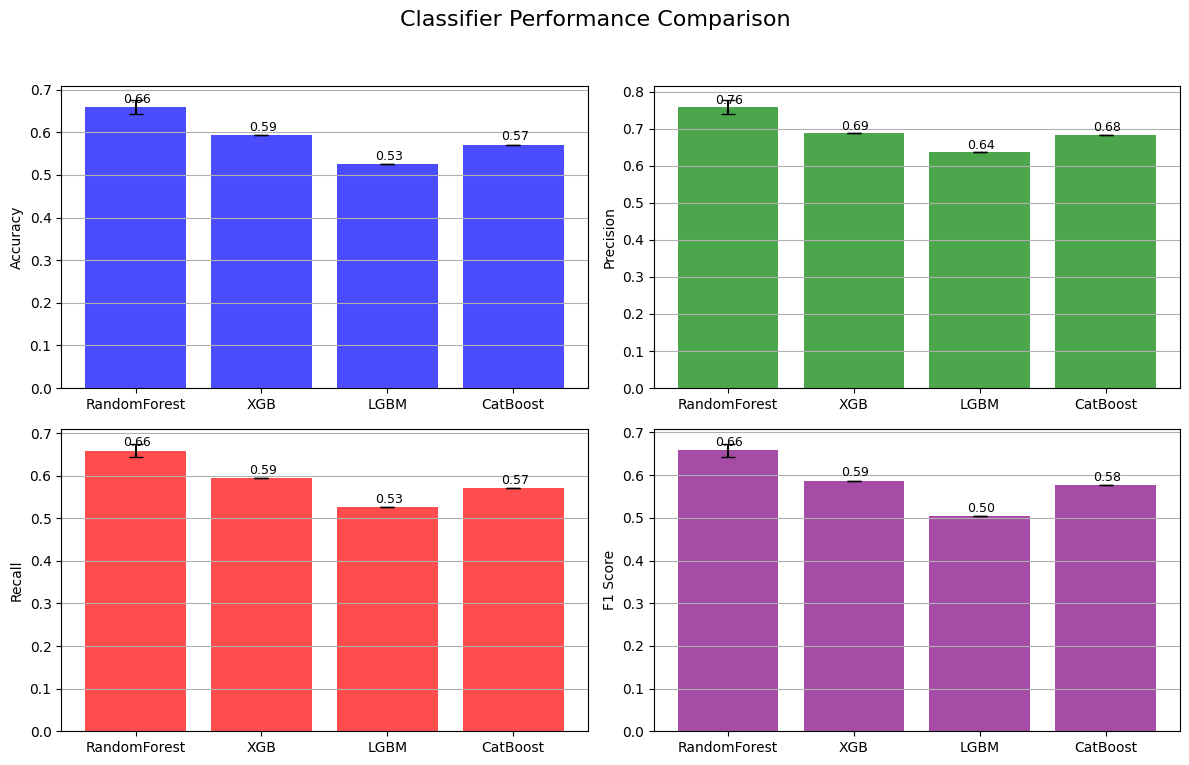

[Text(0, 0, 'RandomForest'),
 Text(1, 0, 'XGB'),
 Text(2, 0, 'LGBM'),
 Text(3, 0, 'CatBoost')]

In [ ]:
classifiers_names = [clf.__class__.__name__ for clf in classifiers]
accuracy_means = [np.mean(results[clf_name]["accuracy"]) for clf_name in classifiers_names]
precision_means = [np.mean(results[clf_name]["precision"]) for clf_name in classifiers_names]
recall_means = [np.mean(results[clf_name]["recall"]) for clf_name in classifiers_names]
f1_means = [np.mean(results[clf_name]["f1"]) for clf_name in classifiers_names]

accuracy_stds = [np.std(results[clf_name]["accuracy"]) for clf_name in classifiers_names]
precision_stds = [np.std(results[clf_name]["precision"]) for clf_name in classifiers_names]
recall_stds = [np.std(results[clf_name]["recall"]) for clf_name in classifiers_names]
f1_stds = [np.std(results[clf_name]["f1"]) for clf_name in classifiers_names]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Classifier Performance Comparison", fontsize=16)
classifiers_names = [clf.__class__.__name__.replace("Classifier", "") for clf in classifiers]

# Accuracy
bars = axes[0, 0].bar(classifiers_names, accuracy_means, yerr=accuracy_stds, capsize=5, color="b", alpha=0.7)
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].grid(axis="y")
axes[0, 0].tick_params(axis="x")
for bar, acc in zip(bars, accuracy_means):
    axes[0, 0].text(bar.get_x() + bar.get_width() / 2 - 0.1, acc + 0.01, f"{acc:.2f}", fontsize=9)

# Precision
bars = axes[0, 1].bar(classifiers_names, precision_means, yerr=precision_stds, capsize=5, color="g", alpha=0.7)
axes[0, 1].set_ylabel("Precision")
axes[0, 1].grid(axis="y")
axes[0, 1].tick_params(axis="x")
for bar, prec in zip(bars, precision_means):
    axes[0, 1].text(bar.get_x() + bar.get_width() / 2 - 0.1, prec + 0.01, f"{prec:.2f}", fontsize=9)

# Recall
bars = axes[1, 0].bar(classifiers_names, recall_means, yerr=recall_stds, capsize=5, color="r", alpha=0.7)
axes[1, 0].set_ylabel("Recall")
axes[1, 0].grid(axis="y")
axes[1, 0].tick_params(axis="x")
for bar, rec in zip(bars, recall_means):
    axes[1, 0].text(bar.get_x() + bar.get_width() / 2 - 0.1, rec + 0.01, f"{rec:.2f}", fontsize=9)

# F1 Score
bars = axes[1, 1].bar(classifiers_names, f1_means, yerr=f1_stds, capsize=5, color="purple", alpha=0.7)
axes[1, 1].set_ylabel("F1 Score")
axes[1, 1].grid(axis="y")
axes[1, 1].tick_params(axis="x")
for bar, f1 in zip(bars, f1_means):
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2 - 0.1, f1 + 0.01, f"{f1:.2f}", fontsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


axes[0, 0].set_xticklabels(classifiers_names, rotation=45)
axes[0, 1].set_xticklabels(classifiers_names, rotation=45)
axes[1, 0].set_xticklabels(classifiers_names, rotation=45)
axes[1, 1].set_xticklabels(classifiers_names, rotation=45)